In [121]:
import math
from glob import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from category_encoders import OneHotEncoder
from joblib import dump, load
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
# from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (ElasticNetCV, LassoCV, LinearRegression,
                                  RidgeCV)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor


In [2]:
sns.set_theme(style="whitegrid", font="Verdana")

In [3]:
%matplotlib inline


# Functions

In [122]:
def show_linear_metrics(y_true: np.array, y_pred: np.array) -> None:
    """Prints linear metrics.

    Parameters
    ----------
    y_true : np.array
        y true
    y_pred : np.array
        y predicted
    """
    print("Mean Absolute Error:", mean_absolute_error(y_true=y_true, y_pred=y_pred))
    print("Mean Squared Error:", mean_squared_error(y_true=y_true, y_pred=y_pred))
    print(
        "Root Mean Squared Error:",
        mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
    )
    print("R^2 Score:", r2_score(y_true=y_true, y_pred=y_pred))


# [Dataset](https://drive.google.com/drive/folders/1nfrYxDm7TLzls9pedZbLX5rP4McVDWDe)

In [9]:
DATASET_PATH = "SSD2022AS2"


In [17]:
csv_files = glob(pathname=path.join(DATASET_PATH, "*.csv"), recursive=True)


In [18]:
dfs = list()

for csv_file in csv_files:
    dfs.append(pd.read_csv(filepath_or_buffer=csv_file))

df = pd.concat(objs=dfs, ignore_index=True)


In [19]:
df.timestamp = pd.to_datetime(df.timestamp)


In [20]:
df


,client_user_id,session_id,dropped_frames,FPS,bitrate,RTT,timestamp,device
0,0164608e-924e-407d-b7c6-f3c3fbaa882a,956d6b48-a337-41a5-8695-d265a6aa06ac,0.0,44.0,50.0,265.0,2022-09-14 08:31:10,Windows
1,0164608e-924e-407d-b7c6-f3c3fbaa882a,956d6b48-a337-41a5-8695-d265a6aa06ac,0.0,45.0,44.0,270.0,2022-09-14 08:31:15,Windows
2,0164608e-924e-407d-b7c6-f3c3fbaa882a,956d6b48-a337-41a5-8695-d265a6aa06ac,0.0,44.0,44.0,272.0,2022-09-14 08:31:20,Windows
3,0164608e-924e-407d-b7c6-f3c3fbaa882a,956d6b48-a337-41a5-8695-d265a6aa06ac,0.0,43.0,43.0,212.0,2022-09-14 08:31:25,Windows
4,0164608e-924e-407d-b7c6-f3c3fbaa882a,956d6b48-a337-41a5-8695-d265a6aa06ac,0.0,44.0,45.0,259.0,2022-09-14 08:31:30,Windows
...,...,...,...,...,...,...,...,...
4035057,fd68eb2f-98c9-4dc6-9724-1dde31ed5cbc,ddc6469e-874f-428d-9a58-6467ae07cd95,0.0,27.0,520.0,0.0,2022-09-19 20:21:35,Windows
4035058,fd68eb2f-98c9-4dc6-9724-1dde31ed5cbc,ddc6469e-874f-428d-9a58-6467ae07cd95,0.0,27.0,501.0,0.0,2022-09-19 20:21:40,Windows
4035059,fd68eb2f-98c9-4dc6-9724-1dde31ed5cbc,ddc6469e-874f-428d-9a58-6467ae07cd95,0.0,27.0,501.0,0.0,2022-09-19 20:21:45,Windows
4035060,fd68eb2f-98c9-4dc6-9724-1dde31ed5cbc,ddc6469e-874f-428d-9a58-6467ae07cd95,0.0,27.0,520.0,0.0,2022-09-19 20:21:50,Windows


# Pipeline

In [108]:
df_ = df.copy()


In [109]:
df_ = df_.groupby(by=["client_user_id", "session_id"]).aggregate(
    {
        "dropped_frames": [np.mean, np.std, np.max],
        "FPS": [np.mean, np.std],
        "bitrate": [np.mean, np.std],
        "RTT": [np.mean, np.std],
        "timestamp": [np.min, np.max, np.ptp],
        "device": [np.unique],
    },
    as_index=False,
)


In [110]:
df_.columns = ["_".join(column).lower() for column in df_.columns.to_flat_index()]

df_ = df_.reset_index()

df_


,client_user_id,session_id,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_amin,timestamp_amax,timestamp_ptp,device_unique
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,8d39d204-d510-43cd-bf49-4df53f5ca0a5,9.166667,27.891519,159.0,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,2022-09-11 22:59:10,2022-09-11 23:18:05,0 days 00:18:55,[Windows]
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf,0.510345,6.243930,92.0,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,2022-09-13 17:01:15,2022-09-13 18:13:50,0 days 01:12:35,[Windows]
2,006e829c-f656-4836-bc04-bafec3901fdc,11542f15-f5f2-4a02-9344-f0bbc8ad06ad,1.359472,7.448480,72.0,29.026398,4.702089,17226.447205,5076.756036,58.000776,9.220387,2022-09-20 21:00:25,2022-09-20 22:50:05,0 days 01:49:40,[Mac]
3,006e829c-f656-4836-bc04-bafec3901fdc,38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180,1.276265,8.476644,86.0,39.822957,5.304531,3930.153696,1532.691830,54.888132,55.603848,2022-09-20 16:45:40,2022-09-20 18:13:00,0 days 01:27:20,[Mac]
4,006e829c-f656-4836-bc04-bafec3901fdc,da0de052-ba6f-4f2c-8053-28d1cdcc0686,0.895911,5.379302,38.0,26.847584,4.424639,13372.773234,4410.790738,16.405204,8.144871,2022-09-06 12:31:15,2022-09-06 12:54:00,0 days 00:22:45,[Windows]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,ff5c29dc-94cf-4e36-8550-d9a2583ca439,ae9d4b9f-66fe-432d-8f80-0f32932a5be0,1.073446,9.303185,148.0,25.733208,3.990694,1795.932831,1495.012451,260.524796,279.533438,2022-09-26 13:37:20,2022-09-26 15:50:45,0 days 02:13:25,[Windows]
4282,ff5c29dc-94cf-4e36-8550-d9a2583ca439,c2ae6769-20a1-4086-817a-877afe436855,0.488956,5.222764,75.0,24.180723,2.892977,877.697791,1386.949540,297.836345,149.122790,2022-09-29 04:30:55,2022-09-29 05:54:05,0 days 01:23:10,[Windows]
4283,ff6840c7-06cc-4b09-89d9-fb680aed5385,641534d9-3328-49d3-b411-fa3ac736045b,0.516746,5.284316,58.0,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,2022-09-23 11:15:25,2022-09-23 11:33:10,0 days 00:17:45,[Windows]
4284,ff88bb69-10c4-41d5-83a7-96663f165c33,2a296f3e-d81f-475d-9d35-6843f91b6e3d,0.000000,0.000000,0.0,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,2022-09-28 16:23:25,2022-09-28 16:42:05,0 days 00:18:40,[Windows]


In [111]:
df_.timestamp_ptp = df_.timestamp_ptp.dt.total_seconds() / 3600
df_.device_unique = df_.device_unique.apply(func=lambda x: ", ".join(x))


In [112]:
df_.to_csv(path_or_buf="output.csv")


In [113]:
df_ = df_.replace(to_replace=np.nan, value=0)


In [114]:
df_


,client_user_id,session_id,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_amin,timestamp_amax,timestamp_ptp,device_unique
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,8d39d204-d510-43cd-bf49-4df53f5ca0a5,9.166667,27.891519,159.0,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,2022-09-11 22:59:10,2022-09-11 23:18:05,0.315278,Windows
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf,0.510345,6.243930,92.0,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,2022-09-13 17:01:15,2022-09-13 18:13:50,1.209722,Windows
2,006e829c-f656-4836-bc04-bafec3901fdc,11542f15-f5f2-4a02-9344-f0bbc8ad06ad,1.359472,7.448480,72.0,29.026398,4.702089,17226.447205,5076.756036,58.000776,9.220387,2022-09-20 21:00:25,2022-09-20 22:50:05,1.827778,Mac
3,006e829c-f656-4836-bc04-bafec3901fdc,38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180,1.276265,8.476644,86.0,39.822957,5.304531,3930.153696,1532.691830,54.888132,55.603848,2022-09-20 16:45:40,2022-09-20 18:13:00,1.455556,Mac
4,006e829c-f656-4836-bc04-bafec3901fdc,da0de052-ba6f-4f2c-8053-28d1cdcc0686,0.895911,5.379302,38.0,26.847584,4.424639,13372.773234,4410.790738,16.405204,8.144871,2022-09-06 12:31:15,2022-09-06 12:54:00,0.379167,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,ff5c29dc-94cf-4e36-8550-d9a2583ca439,ae9d4b9f-66fe-432d-8f80-0f32932a5be0,1.073446,9.303185,148.0,25.733208,3.990694,1795.932831,1495.012451,260.524796,279.533438,2022-09-26 13:37:20,2022-09-26 15:50:45,2.223611,Windows
4282,ff5c29dc-94cf-4e36-8550-d9a2583ca439,c2ae6769-20a1-4086-817a-877afe436855,0.488956,5.222764,75.0,24.180723,2.892977,877.697791,1386.949540,297.836345,149.122790,2022-09-29 04:30:55,2022-09-29 05:54:05,1.386111,Windows
4283,ff6840c7-06cc-4b09-89d9-fb680aed5385,641534d9-3328-49d3-b411-fa3ac736045b,0.516746,5.284316,58.0,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,2022-09-23 11:15:25,2022-09-23 11:33:10,0.295833,Windows
4284,ff88bb69-10c4-41d5-83a7-96663f165c33,2a296f3e-d81f-475d-9d35-6843f91b6e3d,0.000000,0.000000,0.0,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,2022-09-28 16:23:25,2022-09-28 16:42:05,0.311111,Windows


# Data Engineering

In [125]:
df_ = df_.drop(
    labels=["client_user_id", "session_id", "timestamp_amin", "timestamp_amax"], axis=1
)


In [126]:
df_ = OneHotEncoder(cols=["device_unique"], use_cat_names=True).fit_transform(X=df_)


# Split

In [127]:
X = df_.drop(labels=["timestamp_ptp"], axis=1)
y = df_.timestamp_ptp


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


# Session Time

# Model

In [131]:
cat_boost_regressor = CatBoostRegressor()
cat_boost_regressor.fit(X=X_train, y=y_train)

y_pred = cat_boost_regressor.predict(data=X_test)


Learning rate set to 0.050677
0:	learn: 1.6291493	total: 2.91ms	remaining: 2.9s
1:	learn: 1.6159142	total: 5.52ms	remaining: 2.75s
2:	learn: 1.6018471	total: 7.09ms	remaining: 2.36s
3:	learn: 1.5906241	total: 8.79ms	remaining: 2.19s
4:	learn: 1.5795361	total: 10.4ms	remaining: 2.06s
5:	learn: 1.5677112	total: 12ms	remaining: 1.98s
6:	learn: 1.5569404	total: 14.2ms	remaining: 2.02s
7:	learn: 1.5468655	total: 15.9ms	remaining: 1.97s
8:	learn: 1.5371857	total: 17.3ms	remaining: 1.9s
9:	learn: 1.5290669	total: 20.6ms	remaining: 2.04s
10:	learn: 1.5219946	total: 22.2ms	remaining: 2s
11:	learn: 1.5132614	total: 23.6ms	remaining: 1.94s
12:	learn: 1.5052777	total: 25.5ms	remaining: 1.93s
13:	learn: 1.4968963	total: 27.2ms	remaining: 1.91s
14:	learn: 1.4902685	total: 28.8ms	remaining: 1.89s
15:	learn: 1.4837081	total: 30.3ms	remaining: 1.86s
16:	learn: 1.4788692	total: 31.6ms	remaining: 1.83s
17:	learn: 1.4735841	total: 33.2ms	remaining: 1.81s
18:	learn: 1.4679221	total: 34.8ms	remaining: 1.8s


In [142]:
X.columns

Index(['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_amax',
       'fps_mean', 'fps_std', 'bitrate_mean', 'bitrate_std', 'rtt_mean',
       'rtt_std', 'device_unique_Windows', 'device_unique_Mac'],
      dtype='object')

In [141]:
cat_boost_regressor.feature_importances_


array([11.26376757, 11.16829155, 20.79219287, 10.60803399,  7.94241754,
        9.41118507,  8.19646225, 13.238801  ,  6.64846521,  0.3939779 ,
        0.33640506])

In [132]:
dump(cat_boost_regressor, "CatBoostRegressor.joblib")
# cat_boost_regressor = load("CatBoostRegressor.joblib")


['CatBoostRegressor.joblib']

In [39]:
# xgb_regressor = XGBRegressor()
# xgb_regressor.fit(X=X_train, y=y_train)

# y_pred = xgb_regressor.predict(X=X_test)


In [133]:
show_linear_metrics(y_true=y_test, y_pred=y_pred)


Mean Absolute Error: 0.8632510994093926
Mean Squared Error: 2.0584860199079875
Root Mean Squared Error: 1.4347424925428212
R^2 Score: 0.2945071133848618


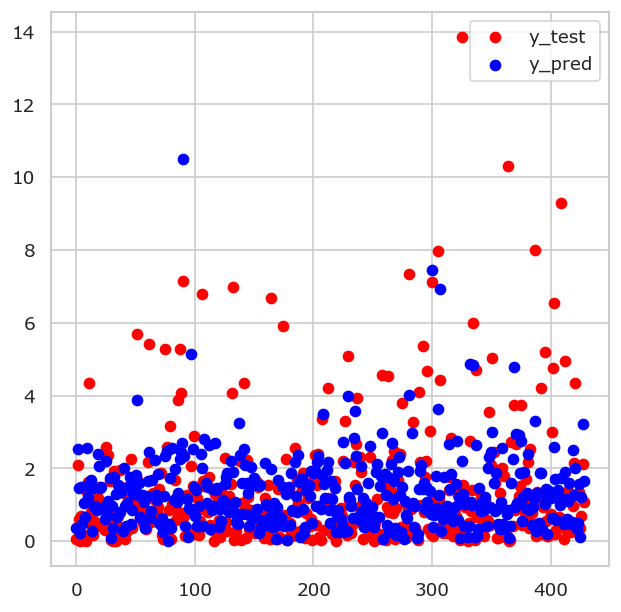

In [138]:
figure = plt.figure(figsize=(6, 6), dpi=120)
subplot = figure.add_subplot()

subplot.scatter(x=np.arange(len(y_test)), y=y_test, c="red", label="y_test")
subplot.scatter(x=np.arange(len(y_pred)), y=np.abs(y_pred), c="blue", label="y_pred")

plt.legend()
plt.show()


# Total Number of Bad Sessions